In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [3]:
from scipy.stats import ks_2samp

### first tryin to get a handle on the data

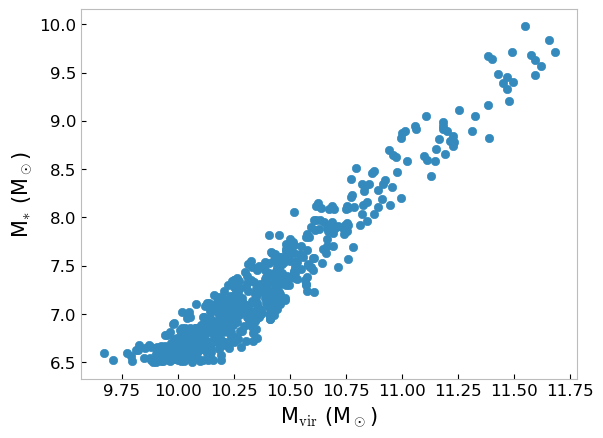

In [4]:
fid_theta = np.array([10.5, 2.0, 0.2, 0, 0, 0])
Ntree = 100
min_mass = 6.5

mock = jsm_models.init_data(fid_theta, "../../../SatGen/mcmc/correlation_test/alpha/mock_1/mock_data.npy")
mock.get_stats(min_mass=min_mass)
mock.get_data_points(plot=True)

In [5]:
counts = []
masses = []

for i in mock.lgMs:
    example = np.sort(i)
    temp = example[~np.isnan(example)]
    short = temp[temp > 6.5]
    counts.append(np.arange(len(short)-1, -1, -1))
    masses.append(short)    

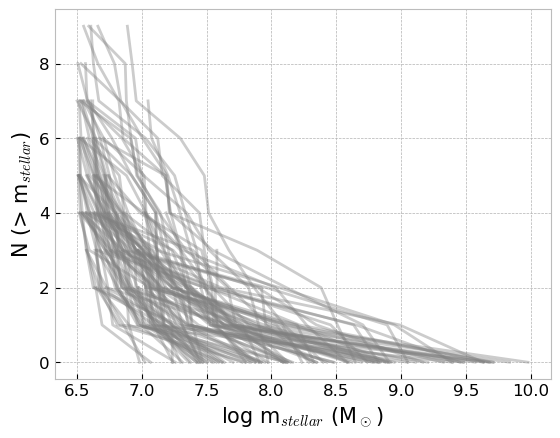

In [6]:
for i, val in enumerate(masses):
    plt.plot(val, counts[i], color="grey", alpha=0.4)

plt.grid()
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.show()

I have no satellites more massive than the maximum stellar mass

In [7]:
def process_array(arr, threshold=6.5):
    sorted_arr = np.sort(arr, axis=1)
    mask = (sorted_arr > threshold) & (~np.isnan(sorted_arr))
    masked_sorted_arr = np.where(mask, sorted_arr, np.nan)
    v = list(map(lambda row: row[~np.isnan(row)], masked_sorted_arr))
    return v

def boolean_indexing(v, fillval=np.nan):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())[::-1]
    out = np.full(mask.shape,fillval)
    out[mask] = np.concatenate(v)
    return out

data = boolean_indexing(process_array(mock.lgMs))

In [8]:
data = boolean_indexing(process_array(mock.lgMs))

In [9]:
countz = np.arange(data.shape[1]-1, -1, -1)

### now the models

In [34]:
models = jsm_models.load_models("../../../data/MW-analog/meta_data_psi3/")

def forward(theta):
    models.push_theta(theta, jsm_SHMR.general, min_mass)
    return models.lgMs

test_theta = np.array([10.5, 1.5, 0.2, 0, 0, 0]) ## thest theta!!!!

lgMs_perf = forward(test_theta)

In [35]:
counts = []
masses = []

for i in lgMs_perf:
    example = np.sort(i)
    temp = example[~np.isnan(example)]
    short = temp[temp > 6.5]
    counts.append(np.arange(len(short)-1, -1, -1))
    masses.append(short)    

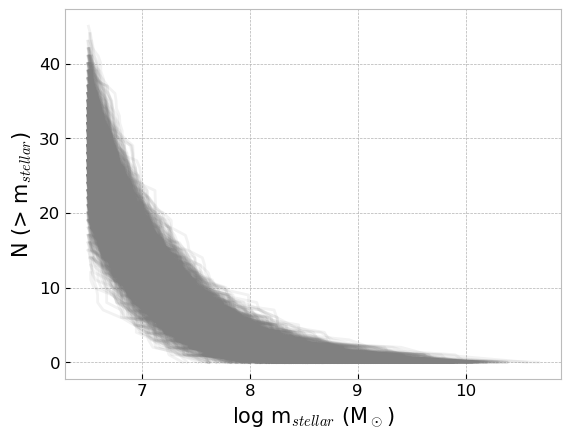

In [36]:
for i, val in enumerate(masses[0:3000]):
    plt.plot(val, counts[i], color="grey", alpha=0.1)

plt.grid()
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.show()

In [13]:
model = boolean_indexing(process_array(lgMs_perf))
model = model[:, -data.shape[1]:]

In [14]:
model = model[:, -data.shape[1]:]

In [15]:
model.shape

(10000, 10)

In [16]:
def KS_visualize(model, data):

    D_stat, p_val =  ks_2samp(model, data)
    data_sorted = np.sort(data)
    ecdf_data = jsm_stats.ecdf_nan(data_sorted)

    model_sorted = np.sort(model)
    ecdf_model = jsm_stats.ecdf_nan(model_sorted)

    lnL = np.log(p_val)
    chi2 = -2*lnL

    plt.figure(figsize=(6,6))
    plt.title(f"D (KS)={D_stat}, p = {p_val} \n lnL = {lnL:.4f}, $\chi^2$={chi2:.4f}")
    plt.plot(data_sorted, ecdf_data, marker="+", color="black")
    plt.plot(model_sorted, ecdf_model, color="grey")
    plt.xlabel("M$_*$ ($\mathrm{log\ M_{\odot}}$)", fontsize=15)
    plt.ylabel("CDF", fontsize=15)
    plt.show()

    return p_val

In [19]:
N_sats_in_each_data = np.sum(~np.isnan(data), axis=0)

In [20]:
N_sats_in_each = np.sum(~np.isnan(model), axis=0)

In [21]:
Ne = (N_sats_in_each * N_sats_in_each_data)/(N_sats_in_each + N_sats_in_each_data)

N (> M) =  9
Ne =  4.997501249375312


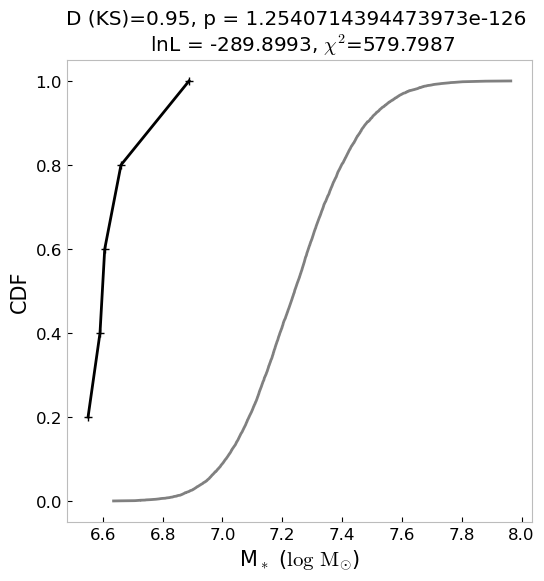

N (> M) =  8
Ne =  7.9936051159072745


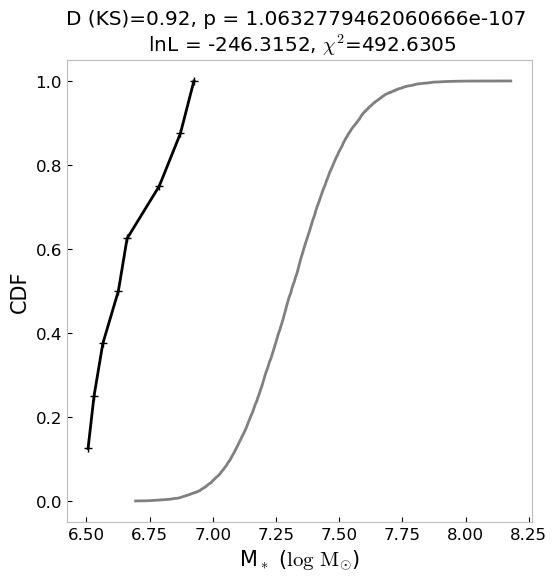

N (> M) =  7
Ne =  18.96396845992614


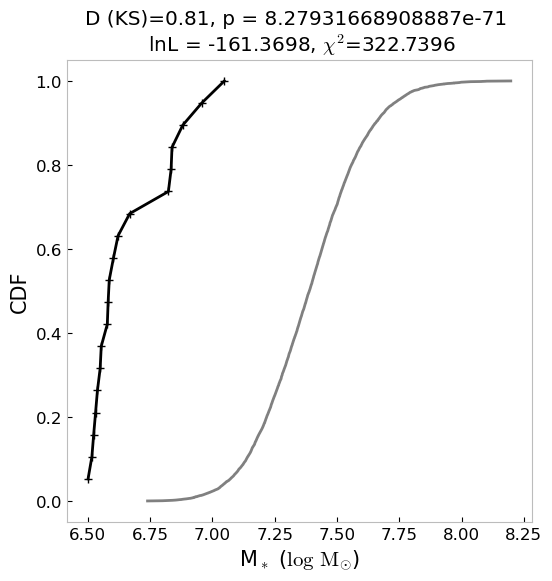

N (> M) =  6
Ne =  32.891458187979666


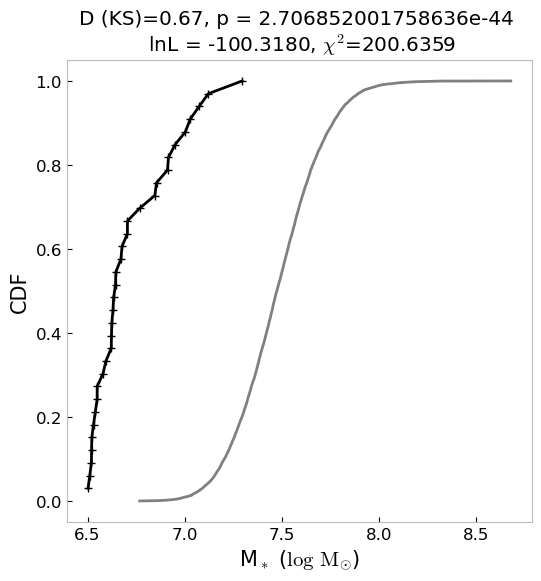

N (> M) =  5
Ne =  50.74121977912645


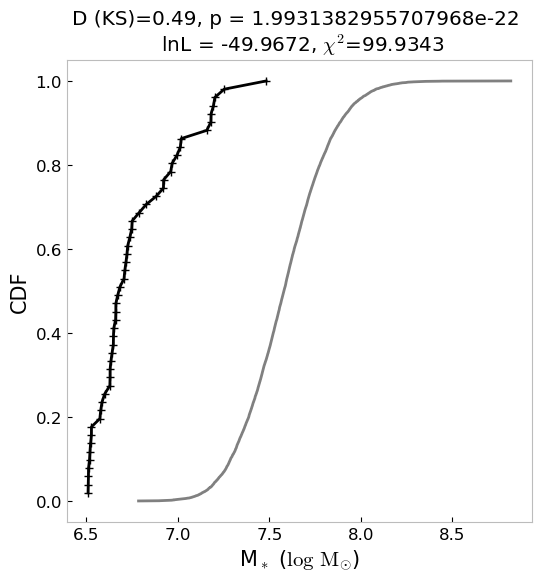

N (> M) =  4
Ne =  76.41163044556912


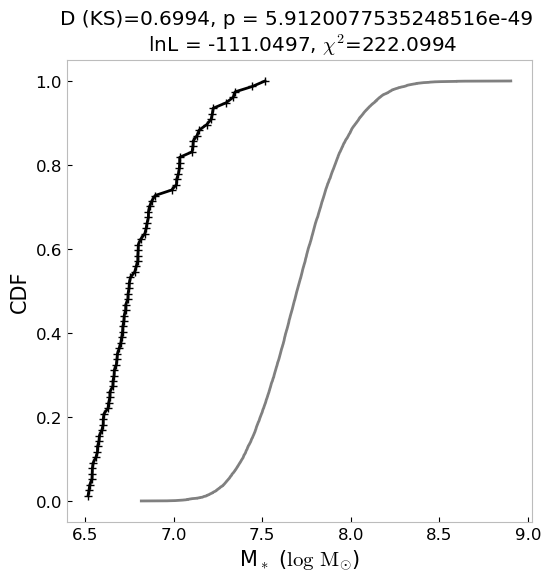

N (> M) =  3
Ne =  90.17936775344366


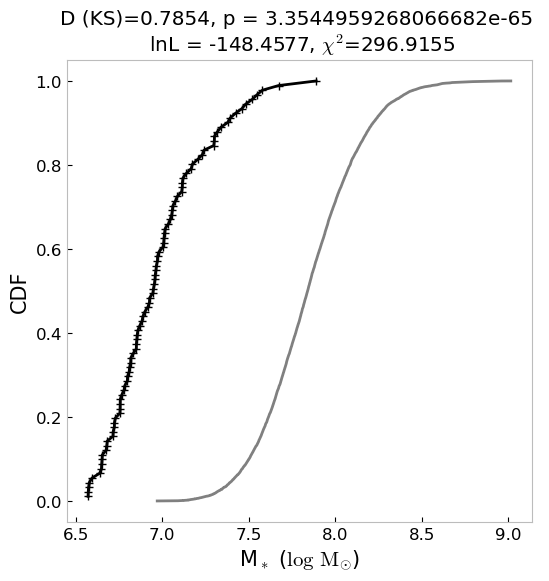

N (> M) =  2
Ne =  99.00990099009901


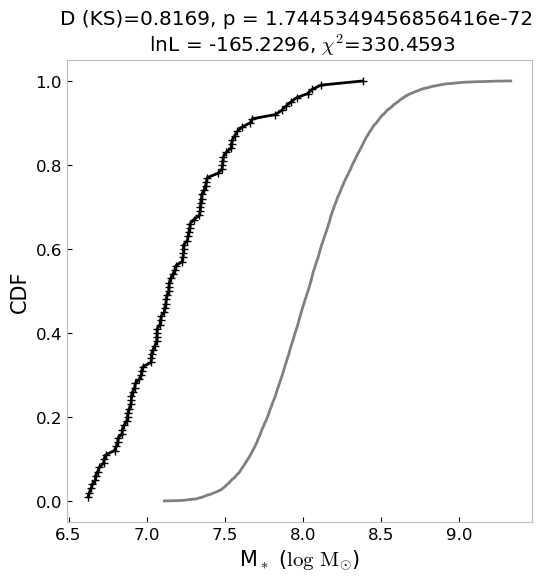

N (> M) =  1
Ne =  99.00990099009901


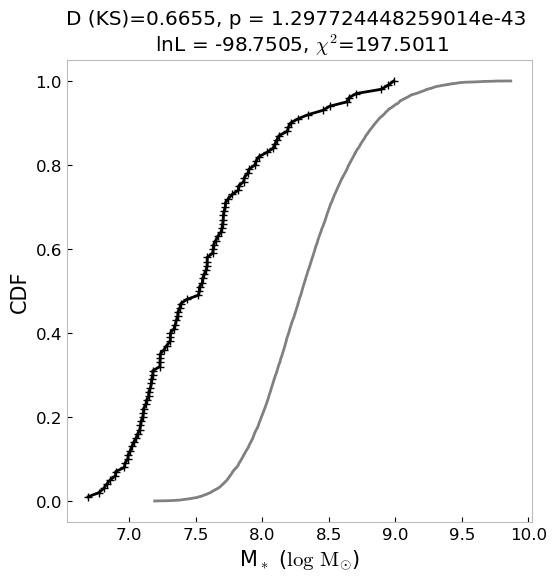

N (> M) =  0
Ne =  99.00990099009901


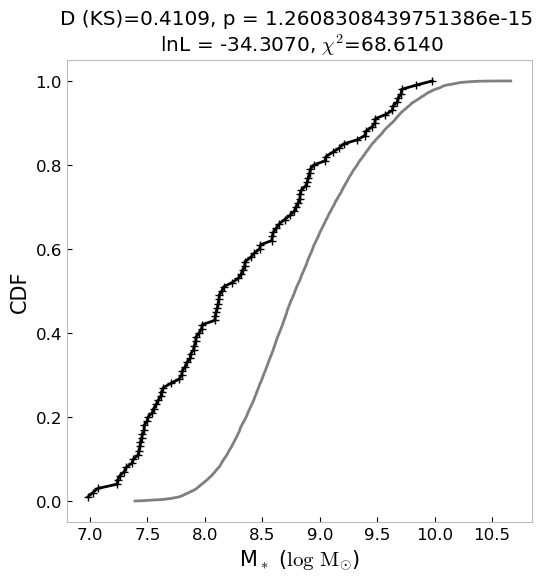

In [22]:
P_vals=[]
for i in range(data.shape[1]):
    print("N (> M) = ", data.shape[1] - i -1)
    print("Ne = ", Ne[i])
    p_val =  KS_visualize(model[:, i], data[:, i])
    P_vals.append(p_val)

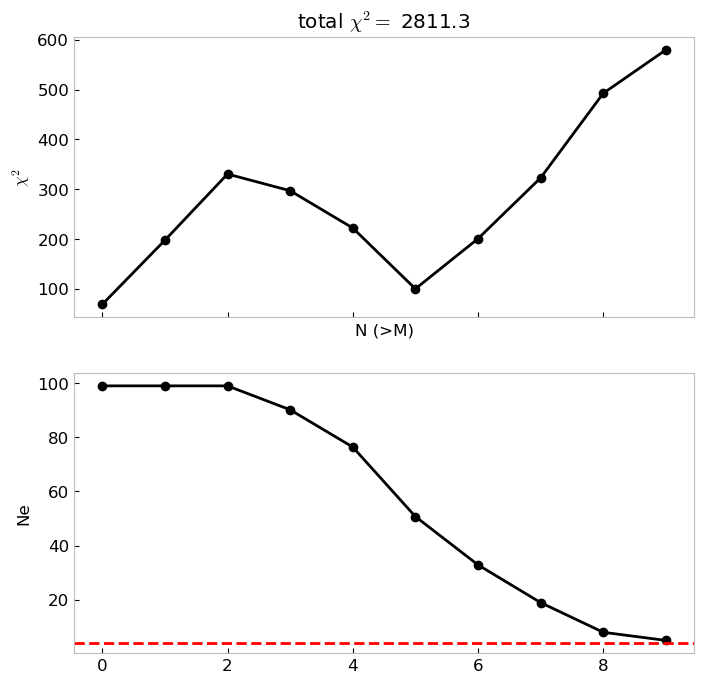

In [23]:
lnL_total = np.sum(np.log(np.array(P_vals)))
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,8))
ax[0].set_title(f"total $\chi^2 =$ {-2*lnL_total:.5}")
ax[0].plot(countz, -2*np.log(np.array(P_vals)), marker="o", color="black")
ax[0].set_xlabel("N (>M)")
ax[0].set_ylabel("$\chi^2$")

ax[1].plot(countz, Ne, marker="o", color="black")
ax[1].set_ylabel("Ne")
ax[1].axhline(4, ls="--", color="red")
plt.show()

In [ ]:
# for i, val in enumerate(masses[0:1000]):
#     plt.plot(val, counts[i], color="grey", alpha=0.1, zorder=0)

# plt.scatter(X_vec_M[0, :], countz, color="red", marker=">")
# plt.scatter(X_vec_M[1, :], countz, color="red", marker="+")
# plt.scatter(X_vec_M[2, :], countz, color="red", marker="<")

# plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
# plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
# plt.show()

In [ ]:
# countz = np.arange(data.shape[1]-1, -1, -1)

In [ ]:
# plt.title()
# plt.fill_betweenx(countz, X_vec_M[0, -X_vec.shape[1]:], X_vec_M[2, -X_vec.shape[1]:], color='grey', alpha=0.3, label="model")

# plt.plot(X_vec[0, :], countz, color="black", marker=">")
# plt.scatter(X_vec[1, :], countz, color="black", marker="+", label="data")
# plt.plot(X_vec[2, :], countz, color="black", marker="<")

# plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
# plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
# plt.legend()
# plt.show()

In [ ]:
# Y_model = X_vec_M[:, -X_vec.shape[1]:]

# Y_data = X_vec

# covariance = np.cov(Y_data, rowvar=1)

# inv_covar = np.linalg.inv(covariance)

# diff = Y_model - Y_data

# chisquare = np.sum(diff.transpose().dot(inv_covar).dot(diff))

In [ ]:
# def lnlike(theta):
#     model = MODEL(theta)
#     X = model - data.D
#     X_vec = np.expand_dims(X, axis=1)
#     chisquare = X_vec.transpose().dot(data.inv_covar).dot(X_vec)
#     return -1/2*np.sum(chisquare)

# self.sampave = np.average(self.D_mat,axis=0)
# self.covariance = np.cov(self.D_mat, rowvar=False)
# self.sampstd = np.sqrt(np.diag(self.covariance))
# self.inv_covar = np.linalg.inv(self.covariance)